## Identify Fraud from Enron Email
#### Project Overview
In this project, you will play detective, and put your machine learning skills to use by building an algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset.

#### Project Introduction
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement, or plea deal with the government, or testified in exchange for prosecution immunity.



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
from time import time
import matplotlib as pl
import matplotlib.pyplot as plt
import pickle

In [3]:
dataPath = '/Users/omojumiller/mycode/MachineLearningNanoDegree/IntroToMachineLearning/'
sys.path.append(dataPath+'tools/')
sys.path.append(dataPath+'final_project/')

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
from helper_files import compareTwoFeatures, computeFraction, findPersonBasedOnTwoFeatures

# Optimize Feature Selection/Engineering
## Task 1: Feature selection

The dataset used in this project is stored in a Python dictionary created by combining the Enron email and financial data, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

POI label: [‘poi’]

You can take a look at this [enron61702insiderpay.pdf](enron61702insiderpay.pdf) file to get a feel of the data yourself.


In [4]:
### Load the dictionary containing the dataset
### The data that I am loading in here is the one that has be cleansed of outliers. 
### For more information on that, refer to the notebook titled "cleanDataForOutliers" in the same folder.

with open('cleaned_dataset.pkl', "r") as data_file:
    data_dict = pickle.load(data_file)

In [5]:
data_dict['PAI LOU L']

{'bonus': 1000000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'lou.pai@enron.com',
 'exercised_stock_options': 15364167,
 'expenses': 32047,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1829457,
 'poi': False,
 'restricted_stock': 8453763,
 'restricted_stock_deferred': 'NaN',
 'salary': 261879,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 3123383,
 'total_stock_value': 23817930}

## Task: Data exploration
- Get descriptive statistics



In [10]:
## Creating a pandas dataframe so that we can easily get descriptive statistics about our features

import itertools


salary = featureFormat(data_dict, ['salary'], remove_any_zeroes=True)
bonus = featureFormat(data_dict, ['bonus'], remove_any_zeroes=True)
exerStockOptions = featureFormat(data_dict, ['exercised_stock_options'], remove_any_zeroes=True)
restrictedStock = featureFormat(data_dict, ['restricted_stock'], remove_any_zeroes=True)

bonus = list(itertools.chain.from_iterable(bonus))
salary = list(itertools.chain.from_iterable(salary))
exerStockOptions = list(itertools.chain.from_iterable(exerStockOptions))
restrictedStock = list(itertools.chain.from_iterable(restrictedStock))




In [11]:
## Pad feature list with zeros to ensure all columns have equal lenght
## Otherwise we won't be able to transfor the individual feature list into a dataframe

size = len(restrictedStock) - len(bonus)
temp = [0.0] * size 

bonus = bonus + temp
print len(bonus)


size = len(restrictedStock) - len(salary)
temp = [0.0] * size 

salary = salary + temp
print len(salary)


size = len(restrictedStock) - len(exerStockOptions)
temp = [0.0] * size 

exerStockOptions = exerStockOptions + temp
print len(exerStockOptions)

108
108
108


count        108.000000
mean      247261.379630
std       190947.697178
min            0.000000
25%       180245.250000
50%       247677.500000
75%       288565.750000
max      1111258.000000
Name: salary, dtype: float64

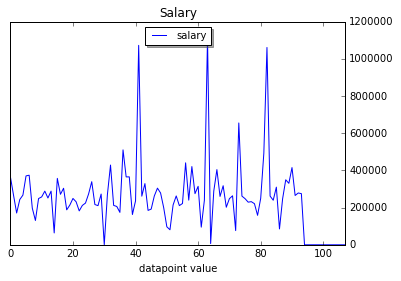

In [13]:
import pandas as pd


df = pd.DataFrame({'salary': salary, 'bonus': bonus, 'exercisedStockOptions': exerStockOptions, 
                   'restrictedStock': restrictedStock})

ax = df['salary'].plot()
ax.yaxis.tick_right()

_= plt.xlabel('datapoint value')
_= plt.title('Salary')

_= plt.legend(loc='upper center', shadow=True, fontsize='medium')

df['salary'].describe()


count         108.000000
mean      2743620.324074
std       5373267.548420
min             0.000000
25%        381597.250000
50%        946696.500000
75%       2234398.250000
max      34348384.000000
Name: exercisedStockOptions, dtype: float64

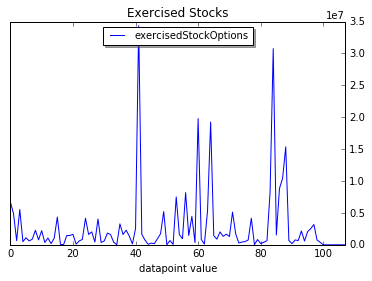

In [14]:
ax2 = df['exercisedStockOptions'].plot()
ax2.yaxis.tick_right()

_= plt.xlabel('datapoint value')
_= plt.title('Exercised Stocks')

_= plt.legend(loc='upper center', shadow=True, fontsize='medium')

df['exercisedStockOptions'].describe()

count         108.000000
mean      1182164.037037
std       2230693.279997
min         32460.000000
25%        257944.000000
50%        451740.000000
75%        990811.250000
max      14761694.000000
Name: restrictedStock, dtype: float64

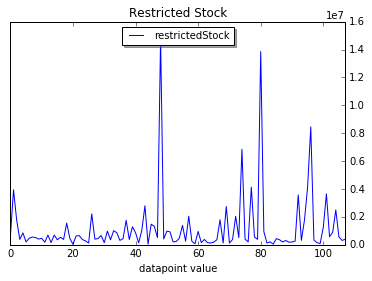

In [15]:
ax2 = df['restrictedStock'].plot()
ax2.yaxis.tick_right()

_= plt.xlabel('datapoint value')
_= plt.title('Restricted Stock')

_= plt.legend(loc='upper center', shadow=True, fontsize='medium')

df['restrictedStock'].describe()

count        108.000000
mean      901329.805556
std      1351777.657207
min            0.000000
25%        52500.000000
50%       600000.000000
75%      1000000.000000
max      8000000.000000
Name: bonus, dtype: float64

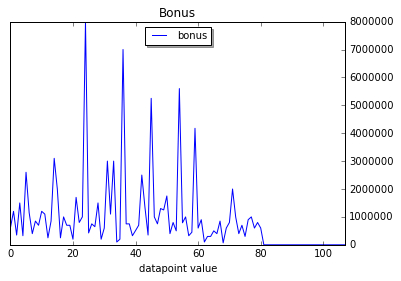

In [16]:
ax2 = df['bonus'].plot()
ax2.yaxis.tick_right()

_= plt.xlabel('datapoint value')
_= plt.title('Bonus')

_= plt.legend(loc='upper center', shadow=True, fontsize='medium')

df['bonus'].describe()

In [17]:
def printLatex(feature1, feature2, the_data_dict, treshold):
    def getKey(item):
        return item[2]

    temp = []
    for key, value in the_data_dict.iteritems():
        if (value[feature1] != "NaN") and (value[feature2] != "NaN" and value[feature2] > treshold):
            temp.append(( key, value[feature1], value[feature2]))
            
    ### print out in ascending order of feature2    
    temp = sorted(temp, key=getKey)
    print "{:20}{:3}{:14}{:3}{:12}{:3}".format("Name".upper(), '&', feature1.upper(), '&', feature2.upper(), '\\\\')
    
    for item in temp:    
        print "{:20}{:3}\${:<14,.2f}{:3}{:12,}{:3}".format(item[0], '&', item[1], '&', item[2], '\\\\')
           
    

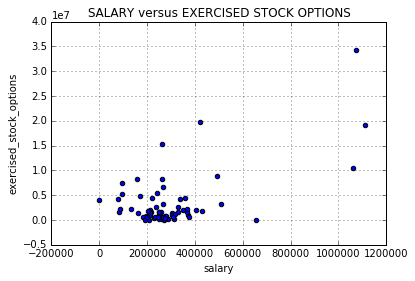

In [18]:
f1, f2 = 'salary','exercised_stock_options'
data = compareTwoFeatures(f1, f2, data_dict, "SALARY versus EXERCISED STOCK OPTIONS")


In [8]:
treshold = 8000000
printLatex(f1, f2, data_dict, treshold)

NAME                &  SALARY        &  EXERCISED_STOCK_OPTIONS\\ 
DIMICHELE RICHARD G &  \$262,788.00    &     8,191,755\\ 
YEAGER F SCOTT      &  \$158,403.00    &     8,308,552\\ 
DERRICK JR. JAMES V &  \$492,375.00    &     8,831,913\\ 
FREVERT MARK A      &  \$1,060,932.00  &    10,433,518\\ 
PAI LOU L           &  \$261,879.00    &    15,364,167\\ 
SKILLING JEFFREY K  &  \$1,111,258.00  &    19,250,000\\ 
RICE KENNETH D      &  \$420,636.00    &    19,794,175\\ 
LAY KENNETH L       &  \$1,072,321.00  &    34,348,384\\ 


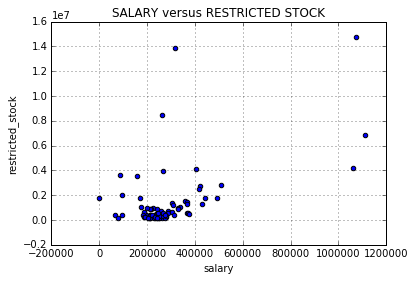

In [19]:
f1, f2 = 'salary','restricted_stock'
data = compareTwoFeatures(f1, f2, data_dict, "SALARY versus RESTRICTED STOCK")



In [ ]:
treshold = 3000000
printLatex(f1, f2, data_dict, treshold)

In [ ]:
f1, f2 = 'salary','bonus'
data = compareTwoFeatures(f1, f2, data_dict, "SALARY versus BONUS")

data = featureFormat(data_dict, [f2], remove_any_zeroes=True)

_= plt.plot(data, color="blue", label=f2)
_= plt.legend(loc='upper right', shadow=True, fontsize='small')
_= plt.xlabel('Employee number', fontsize=10)
_= plt.ylabel('Counts', fontsize=10)
_= plt.title('BONUS')

plt.show()

In [ ]:
treshold = 4000000
printLatex(f1, f2, data_dict, treshold)

In [ ]:
data_dict['LAVORATO JOHN J']

In [ ]:
import pandas as pd

data = pd.DataFrame({'poi':labels})
ax = data.plot.hist()
ax.yaxis.tick_right()

_= plt.xlabel('datapoint value')
_= plt.title('Histogram of Person of Interest')
_= plt.legend(loc='upper center', shadow=True, fontsize='medium')
_= plt.axis([0, 1, 0, 200])


### Engineered Feature
- #### Fraction of messages to and from POI

In [ ]:
submit_dict = {}
for name in data_dict:

    data_point = data_dict[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    #print'{:5}{:35}{:.2f}'.format('FROM ', name, fraction_from_poi)
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    #print fraction_to_poi
    #print'{:5}{:35}{:.2f}'.format('TO: ', name, fraction_to_poi)
    submit_dict[name]={"from_poi_to_this_person":fraction_from_poi,
                       "from_this_person_to_poi":fraction_to_poi}
    
    data_point["fraction_to_poi"] = fraction_to_poi
    


In [ ]:
f1, f2 = 'fraction_from_poi','fraction_to_poi'
data = compareTwoFeatures(f1, f2, data_dict, '')

## PCA

## Task 3: Create new feature(s)
- features_list is a list of strings, each of which is a feature name.
- The first feature must be "poi".
- Store to `my_dataset` for easy export below.

In [ ]:
feature_list = ['poi','salary', 'bonus', 'exercised_stock_options', 'restricted_stock']
# 'fraction_from_poi','fraction_to_poi',
# 'from_poi_to_this_person','from_this_person_to_poi'
#  


In [ ]:
my_dataset = data_dict

Extract features and labels from dataset for local testing

In [ ]:
data = featureFormat(my_dataset, feature_list
                     , sort_keys = True)
labels, features = targetFeatureSplit(data)

# Pick and Tune an Algorithm
## Task 4: Try a variety of classifiers
- Please name your classifier clf for easy export below.
- Note that if you want to do PCA or other multi-stage operations, you'll need to use Pipelines. For more info: http://scikit-learn.org/stable/modules/pipeline.html

# Validate and Evaluate
## Task 5: Tune your classifier
- Achieve better than .3 precision and recall. Using our testing script. Check the `tester.py` script in the final project folder for details on the evaluation method, especially the test_classifier function. Because of the small size of the dataset, the script uses `stratified shuffle split cross validation`. For more info: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


In [ ]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score 

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, features, labels)
print scores, "\n"        

test_classifier(clf, my_dataset, feature_list, folds = 100)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=10)   
scores = cross_val_score(clf, features, labels)
print scores, "\n"

test_classifier(clf, my_dataset, feature_list, folds = 100)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=1, random_state=0)
scores = cross_val_score(clf, features, labels)
print scores, "\n"

test_classifier(clf, my_dataset, feature_list, folds = 100)

## Task 6: Export solution
Dump your classifier, dataset, and features_list so anyone can check your results. You do not need to change anything below, but make sure that the version of `poi_id.py` that you submit can be run on its own and generates the necessary .pkl files for validating your results.

In [ ]:
#dump_classifier_and_data(clf, my_dataset, feature_list)